In [1]:
import datetime
import sklearn
print(sklearn.__version__)
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from glob import glob
from copy import deepcopy
from Bio import AlignIO
from anytree import RenderTree
from pypdb import Query, get_pdb_file

# from dist_analy.pypdb import Query, get_pdb_file
from dist_analy.dist_analy import get_shortest_dist_matrix, get_ca_dist_matrix
import dist_analy.import_pdb
import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info, pdb_read_csv
# from dist_analy.alphaspace2.Community import get_community, view_surf_community, view_pocket
from dist_analy.tree_analysis import TreeNode

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

1.3.2


In [2]:
current_date = datetime.datetime.now()

print("The code was last run on:", current_date)

The code was last run on: 2024-02-05 17:02:58.715306


### Get the list of conserved residues across the CDK family

In [3]:
UNIPROT_LIST = ["P06493", "P24941", "Q00526", "P11802", "Q00535", "Q00534", "P50613", "P49336", "P50750", "Q15131", "Q9UQ88", "P21127", "Q9NYV4", \
"Q14004", "O94921", "Q96Q40", "Q00536", "Q00537", "Q07002", "Q9BWU1", "Q8IZL9"]
CDK1_20 = ['CDK1_HUMAN','CDK2_HUMAN','CDK3_HUMAN','CDK4_HUMAN','CDK5_HUMAN','CDK6_HUMAN','CDK7_HUMAN','CDK8_HUMAN','CDK9_HUMAN','CDK10_HUMAN','CD11A_HUMAN','CD11B_HUMAN','CDK12_HUMAN','CDK13_HUMAN','CDK14_HUMAN','CDK15_HUMAN','CDK16_HUMAN','CDK17_HUMAN','CDK18_HUMAN','CDK19_HUMAN','CDK20_HUMAN']

# alignment = get_and_align_sequence('./datafiles/', 'CDK1_20', UNIPROT_LIST, prot_list=CDK1_20)
align = AlignIO.read('./datafiles/align/CDK1_20.al', "clustal")
cons_id = get_conserved(align)

klifs_res = [res for res in get_klifs_res('1FIN','A') if res]
cdk2_klifs_ident, union_id = def_union(cons_id[CDK1_20.index('CDK2_HUMAN')], klifs_res)

### Get the uniprot sequence for each kinase of the CDK family

In [4]:
uniprot_root = 'https://www.ebi.ac.uk/proteins/api/proteins/'
uniprot_seq_cdk2 = get_any_info(uniprot_root, UNIPROT_LIST[CDK1_20.index('CDK2_HUMAN')])["sequence"]["sequence"]

In [5]:
color_list = ['red', 'orange_red_1', 'yellow', 'green_1', 'dark_green', 'cyan', 'blue', 'purple_1b', 'magenta'] ## change to hex code
color_list = ['#e50000', '#f97306', '#ceb301', '#96f97b', '#06470c', '#00ffff', '#0343df', '#7e1e9c', '#cb416b']
cdk2_color_res_list = [np.arange(12,17), np.delete(np.arange(45,58), np.where(np.arange(45,58)==51)), \
              np.arange(80,87), np.delete(np.arange(125,132), np.where(np.arange(125,132)==127)), \
               np.array([33,51,127,145]), np.arange(146,172),np.arange(182,197)]

color_cdk2 = dist_analy.pca.color_text(color_list, cdk2_color_res_list)


### Get all of the PDB structures associated with the CDK2 uniprot ID

In [6]:
cdk2_uniprot = 'P24941'
found_pdbs = Query(cdk2_uniprot, query_type="uniprot").search()

In [11]:
outdir = './datafiles/raw_pdb/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

remove_list = []
for pdb in found_pdbs:
    fn = f"{outdir}{pdb}.pdb"
    if not os.path.exists(fn):
        pdb_file = get_pdb_file(pdb, filetype='pdb', compression=False)
        if pdb_file is not None:
            with open(fn,'w') as f1:
                f1.write(pdb_file)
        else:
            print(f"Unable to retrieve {pdb}")
            remove_list.append(pdb)

for remove in remove_list[::-1]:
    found_pdbs.remove(remove)

In [8]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'

proc_pdb_list = []
NCAA = ['TPO', 'CSD', 'KCX', 'CSD', 'PTR', 'OCS', 'ALY']
pdb_proc = dist_analy.import_pdb.PDB_Processer(NCAA)
for pdb_fn in found_pdbs:
    if not glob(f'{proc_dir}{pdb_fn}*.pdb'):
        pdb_list = pdb_proc.process_pdb(pdb_fn+'.pdb', pdb_dir, proc_dir, cdk2_uniprot)
        for proc in pdb_list:
            proc_pdb_list.append(proc)

### Create a .csv file with the characteristics of each of the PDB files

In [56]:
csv_dict = pdb_csv(found_pdbs, cdk2_uniprot, "cdk2_pdb.csv")

In [9]:
csv_dict, csv_df = pdb_read_csv("cdk2_pdb.csv")

### Calculate and save the distance matrices

In [12]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/CDK2/"

dist_mat_list_0 = []
dist_mat_pdb_0 = []
for proc in glob(proc_dir+'*'):
    pdb = proc.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    save_fn = f'{save_dir}{pdb}.npy'
    if os.path.exists(save_fn):
        dist_mat = np.load(save_fn, allow_pickle=True)
        dist_mat_list_0.append(dist_mat)
        dist_mat_pdb_0.append(pdb)
    else:
        dist_mat = get_shortest_dist_matrix(proc, cdk2_klifs_ident, chain, save_dir=save_dir)
        dist_mat_list_0.append(dist_mat)
        dist_mat_pdb_0.append(pdb)

#### remove the structures that are missing more than 50 residues

removing 8OR0_H
removing 8OR4_H


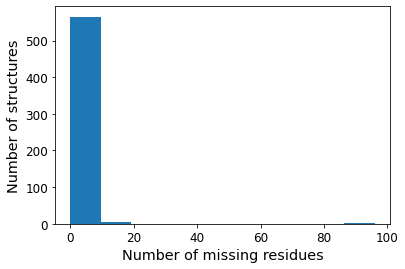

In [13]:
remove_proc = dist_analy.pca.hist_missing_structure(dist_mat_list_0, cutoff=50)
for remove in remove_proc[::-1]:
    print(f"removing {dist_mat_pdb_0[remove]}")
    del dist_mat_pdb_0[remove]
    del dist_mat_list_0[remove]

#### observe the frequently unresolved/missing residues from the distance matrices

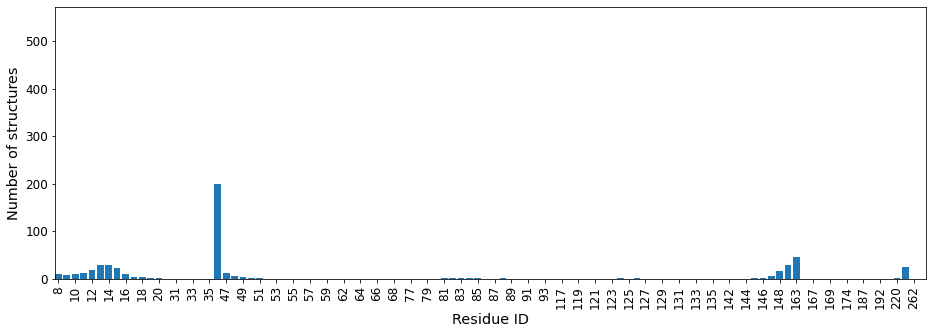

In [14]:
missing_pdb, missing_res = dist_analy.pca.hist_missing_residue(dist_mat_list_0, cdk2_klifs_ident)

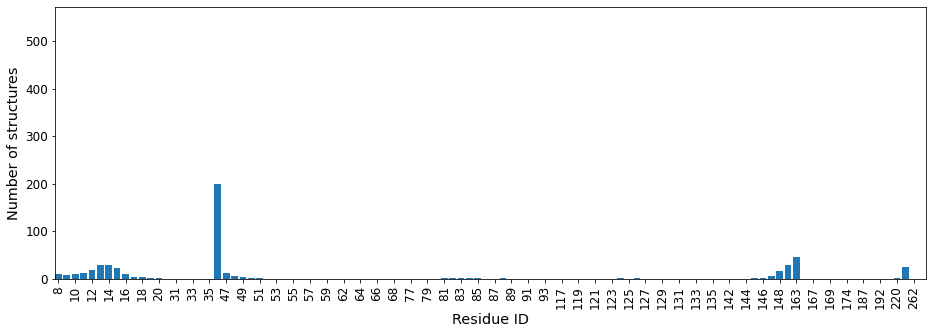

In [15]:
res_get = [145,146,147]
missing_dfg = dist_analy.pca.hist_missing_residue(dist_mat_list_0, cdk2_klifs_ident, res_get)

In [16]:
print(len(dist_mat_list_0))

571


removing residues not available in every structure
original length of residue list 104; remove 35 residues
Cumulative explained variance > 0.8: 0.68, 0.05, 0.03, 0.02, 0.02
noise (6): 8BYA_A 5OO1_A 3QQH_A 4NJ3_A 7UXI_A 8CUR_A
1 (6): 3PXZ_A 3PY1_A 7UG1_A 3PXF_A 3PXQ_A 4EZ7_A
2 (244): 1H1R_C 6GUE_C 1H1P_A 1URC_A 1PKD_C 1QMZ_C 2BPM_A 5NEV_C 2WMA_A 3BHT_C 3BHV_A 2CJM_A 4EOP_C 4EOI_A 1OL2_A 4EOR_A 4EOK_C 4I3Z_A 4I3Z_C 4EOK_A 4EOR_C 1OL2_C 4EOI_C 4EOP_A 2CJM_C 3BHV_C 3BHT_A 2WMA_C 5NEV_A 2BPM_C 1QMZ_A 1PKD_A 1URC_C 1H1P_C 6GUE_A 1H1R_A 4CFU_A 2IW9_C 2X1N_A 1JST_A 4CFW_C 4CFN_A 3MY5_C 2C6T_C 7QHL_A 1VYW_A 1FVV_A 6GUC_C 4EOM_C 4EOO_A 7B7S_C 5LMK_C 7MKX_A 7MKX_C 5LMK_A 7B7S_A 4EOO_C 4EOM_A 1FVV_C 6GUC_A 1VYW_C 7QHL_C 2C6T_A 3MY5_A 4CFN_C 4CFW_A 1JST_C 2X1N_C 2IW9_A 4CFU_C 3BHU_A 2BKZ_C 4EOQ_A 1OL1_A 4EOJ_A 4EOS_C 1P5E_C 1OIY_A 2V22_A 1H1S_A 1H28_C 2I40_A 6GUF_C 3TNW_C 1H1Q_C 2UUE_C 2WMB_A 2WMB_C 2UUE_A 1H1Q_A 3TNW_A 6GUF_A 2I40_C 1H28_A 1OIY_C 1H1S_C 2V22_C 1P5E_A 4EOS_A 4EOJ_C 1OL1_C 4EOQ_C 2B

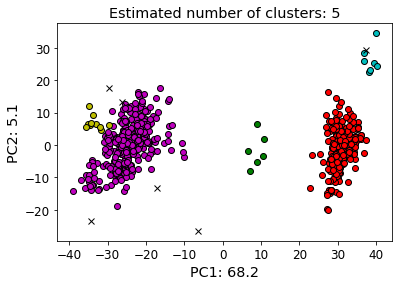

In [28]:
dist_mat_list_0 = np.array(dist_mat_list_0)
dist_mat_pdb_0 = np.array(dist_mat_pdb_0)
proj_0, labels_0, dist_mats_0, res_list_0, ind_list_0, pca_0, hdbscan_0 = dist_analy.pca.run(dist_mat_list_0, cdk2_klifs_ident)
inds_fc_0 = [[j for j,l in enumerate(labels_0) if l==i ] for i in range(min(labels_0),max(labels_0)+1)]

for i, inds_fc in enumerate(inds_fc_0):
    print(f"{i if i > 0 else 'noise'} ({len(inds_fc)}): {' '.join(dist_mat_pdb_0[inds_fc])}")

In [29]:
minor_binder_list = []
major_binder_list = []
polymer_binder_list = []
modifications_list = []
# for pdb_chain in [dist_mat_pdb_0[x] for ind_fc in inds_fc_0 for x in ind_fc]:
for pdb_chain in dist_mat_pdb_0:
    pdb = pdb_chain.split('_')[0]
    pdb_dict = csv_dict[pdb]
#     minor_binder_list.append()

    major_binder_list.append(set((pdb_dict['Major Binders'] or []) + (pdb_dict['Minor Binders'] or [])))
    polymer_binder_list.append(pdb_dict['Polymer Binders'])
    modifications_list.append(pdb_dict['Modifications'])

In [30]:
root = TreeNode("All CDK2",num_cluster=6, inds_fc=inds_fc_0)
c1a,c1b,c1c = root.gen_children("Cyclin bound","cyclin",polymer_binder_list,modif=False, not_key=["inhibitor"])

c2a,c2b,c2c=c1a.gen_children("TPO166 modified","tpo",modifications_list,modif=False)
c2d,c2e,c2f=c1c.gen_children("CYS177 modified","csd",modifications_list,modif=False)

c2a.gen_children("ATP/ADP bound",["atp","adp"],major_binder_list,modif=False)
c2c.gen_children("ATP/ADP bound",["atp","adp"],major_binder_list,modif=False)
c2f.gen_children("ATP/ADP bound",["atp","adp"],major_binder_list,modif=False)
            
for pre, _, node in RenderTree(root):
    #print(pre)
    treestr ="%s%s %s %i"%(pre, node.name,node.cluster_count,sum(node.cluster_count))
    print(treestr)

All CDK2 [6, 6, 244, 7, 298, 10] 571
├── Cyclin bound [1, 0, 237, 7, 0, 0] 245
│   ├── TPO166 modified [1, 0, 169, 7, 0, 0] 177
│   │   ├── ATP/ADP bound [0, 0, 28, 0, 0, 0] 28
│   │   ├── Other [0, 0, 125, 5, 0, 0] 130
│   │   └── None [1, 0, 16, 2, 0, 0] 19
│   ├── Other [0, 0, 0, 0, 0, 0] 0
│   └── None [0, 0, 68, 0, 0, 0] 68
│       ├── ATP/ADP bound [0, 0, 2, 0, 0, 0] 2
│       ├── Other [0, 0, 50, 0, 0, 0] 50
│       └── None [0, 0, 16, 0, 0, 0] 16
├── Other [1, 0, 6, 0, 2, 0] 9
└── None [4, 6, 1, 0, 296, 10] 317
    ├── CYS177 modified [1, 0, 0, 0, 11, 0] 12
    ├── Other [0, 0, 1, 0, 51, 0] 52
    └── None [3, 6, 0, 0, 234, 10] 253
        ├── ATP/ADP bound [0, 0, 0, 0, 2, 0] 2
        ├── Other [3, 6, 0, 0, 228, 10] 247
        └── None [0, 0, 0, 0, 4, 0] 4


cluster 3 stabilizing interactions


<span style='color: #f97306'>E57</span>-R122: 2.024, 17.008

<span style='color: #f97306'>L55</span>-<span style='color: #ceb301'>F80</span>: 2.993, 6.748

<span style='color: #f97306'>L55</span>-V64: 3.354, 5.974

<span style='color: #f97306'>L55</span>-I63: 3.488, 4.832

<span style='color: #f97306'>L54</span>-V123: 3.293, 4.176

<span style='color: #f97306'>S53</span>-<span style='color: #f97306'>L54</span>: 2.180, 4.019

cluster 5 stabilizing interactions


<span style='color: #f97306'>S53</span>-V69: 3.034, -5.572

<span style='color: #f97306'>K56</span>-K65: 2.546, -5.287

F117-C118: 2.474, -4.954

<span style='color: #f97306'>K56</span>-L67: 2.755, -4.691

<span style='color: #f97306'>K56</span>-D68: 2.817, -4.235

<span style='color: #06470c'>D127</span>-<span style='color: #00ffff'>R169</span>: 2.438, -4.201

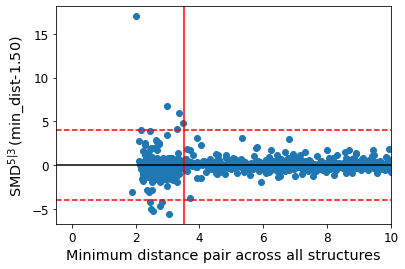

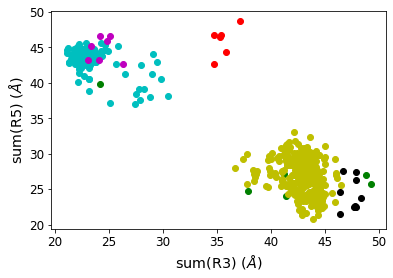

In [32]:
c1 = 4
c2 = 2

feats_0 = dist_analy.pca.triu_flatten(dist_mats_0, len(res_list_0))

smd_0, min_dist_0 = dist_analy.pca.calc_cluster_smd(inds_fc_0[c1], inds_fc_0[c2], feats_0, std = 'SMD')
r1r2_feat_0 = dist_analy.pca.plot_smd(c1, c2, feats_0, min_dist_0, smd_0, [res_list_0], [uniprot_seq_cdk2], [color_cdk2], xcutoff=3.5, ycutoff=4, top=25)
dist_analy.pca.plot_r1r2(c1,c2,r1r2_feat_0, inds_fc_0, dist_mats_0)


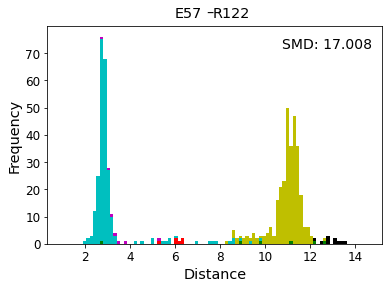

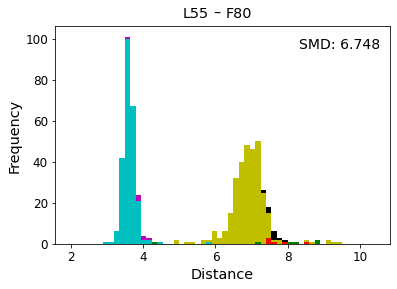

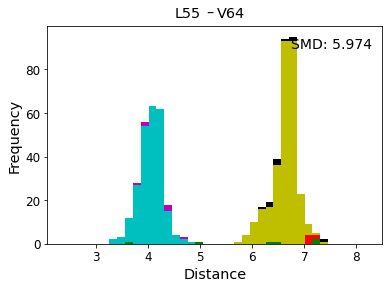

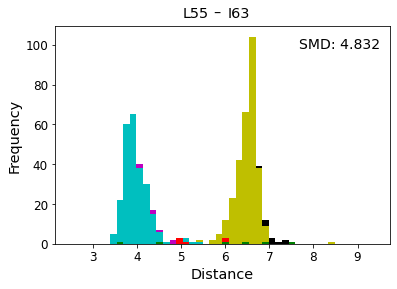

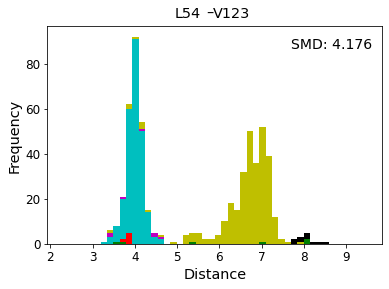

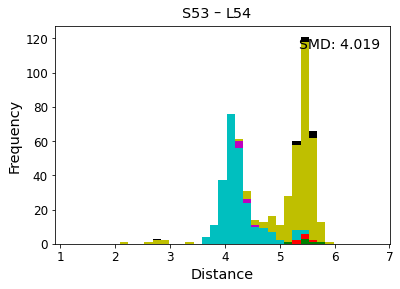

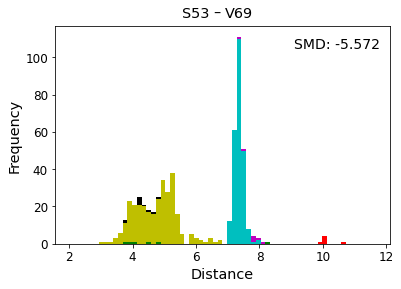

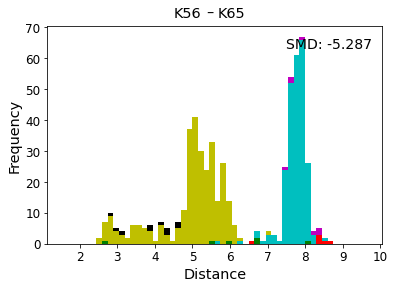

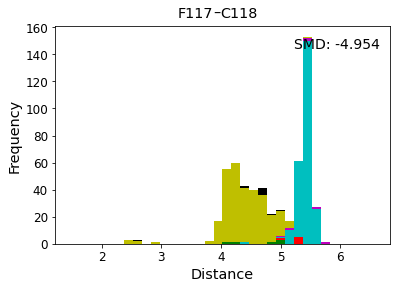

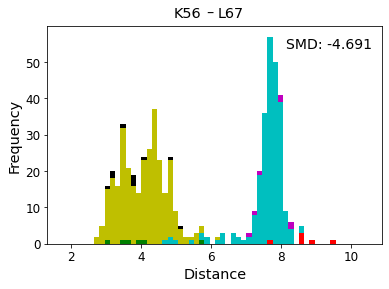

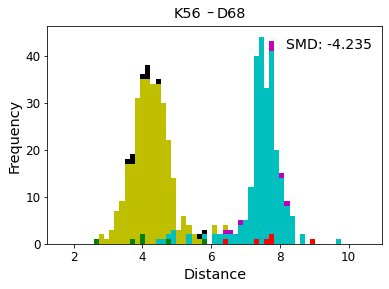

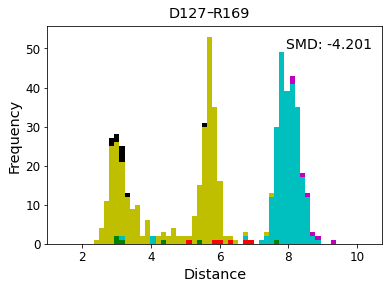

In [33]:
for r1,r2,index, shortest, smd in r1r2_feat_0:
    dist_analy.pca.plot_stacked_histogram(r1,r2,dist_mats_0,[res_list_0],inds_fc_0,[uniprot_seq_cdk2],SMD=smd)